In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')


# Load full preprocessed training data
train_processed = pd.read_csv('../data/processed/train_processed.csv')

print(f"✓ Training data loaded: {train_processed.shape}")

# Separate features and target
X = train_processed.drop(['Id', 'SalePrice'], axis=1)
y = train_processed['SalePrice']

# Log transform target 
y_log = np.log1p(y)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")

# Handle any remaining NaN or inf
X = X.fillna(0).replace([np.inf, -np.inf], 0)

print(f"\nTarget (SalePrice) statistics:")
print(f"  Mean: ${y.mean():,.0f}")
print(f"  Median: ${y.median():,.0f}")
print(f"  Std: ${y.std():,.0f}")
print(f"  Range: ${y.min():,.0f} - ${y.max():,.0f}")


✓ Training data loaded: (1460, 233)

Features shape: (1460, 231)
Target shape: (1460,)
Number of features: 231

Target (SalePrice) statistics:
  Mean: $180,921
  Median: $163,000
  Std: $79,443
  Range: $34,900 - $755,000


In [2]:


# Split: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")


# Define models with their hyperparameter search spaces
models_config = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}  # No hyperparameters
    },
    
    'Polynomial Regression': {
        'model': Pipeline([
            ('poly', PolynomialFeatures()),
            ('linear', LinearRegression())
        ]),
        'params': {
            'poly__degree': [2, 3],
            'poly__include_bias': [True, False]
        }
    },
    
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr']
        }
    },
    
    'Lasso': {
        'model': Lasso(max_iter=10000),
        'params': {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
            'selection': ['cyclic', 'random']
        }
    },
    
    'ElasticNet': {
        'model': ElasticNet(max_iter=10000),
        'params': {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99],
            'selection': ['cyclic', 'random']
        }
    },
    
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['auto', 'sqrt', 'log2', None]
        }
    },
    
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf', 'poly'],
            'C': [0.1, 1.0, 10.0, 100.0],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'epsilon': [0.01, 0.1, 0.2]
        }
    },
    
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree'],
            'p': [1, 2]  # 1: manhattan, 2: euclidean
        }
    }
}

print(f"✓ Configured {len(models_config)} models for training")


#MODEL TRAINING WITH HYPERPARAMETER TUNING



Training set: 1168 samples (80.0%)
Validation set: 292 samples (20.0%)
✓ Configured 8 models for training


In [3]:

#MODEL TRAINING WITH HYPERPARAMETER TUNING
results = []
trained_models = {}

for model_name, config in models_config.items():
    print(f"\n{'='*70}")
    print(f"Training: {model_name}")
    print(f"{'='*70}")
    
    model = config['model']
    params = config['params']
    
    if len(params) > 0:
        # Hyperparameter tuning with RandomizedSearchCV
        print(f"  Performing RandomizedSearchCV...")
        print(f"  Parameter combinations to try: {len(params)}")
        
        random_search = RandomizedSearchCV(
            model,
            param_distributions=params,
            n_iter=20,  # Try 20 random combinations
            cv=5,       # 5-fold cross-validation
            scoring='neg_mean_squared_error',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        
        random_search.fit(X_train, y_train)
        
        best_model = random_search.best_estimator_
        print(f"  ✓ Best parameters found:")
        for param, value in random_search.best_params_.items():
            print(f"    {param}: {value}")
    else:
        # No hyperparameters to tune
        print(f"  Training without hyperparameter tuning...")
        best_model = model
        best_model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    
    # Convert back from log scale
    y_train_pred_orig = np.expm1(y_train_pred)
    y_val_pred_orig = np.expm1(y_val_pred)
    y_train_orig = np.expm1(y_train)
    y_val_orig = np.expm1(y_val)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
    val_rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_orig))
    
    train_mae = mean_absolute_error(y_train_orig, y_train_pred_orig)
    val_mae = mean_absolute_error(y_val_orig, y_val_pred_orig)
    
    train_r2 = r2_score(y_train_orig, y_train_pred_orig)
    val_r2 = r2_score(y_val_orig, y_val_pred_orig)
    
    # Calculate overfitting measure
    overfitting = train_r2 - val_r2
    
    print(f"\n  Results:")
    print(f"    Train RMSE: ${train_rmse:,.0f}")
    print(f"    Val RMSE:   ${val_rmse:,.0f}")
    print(f"    Train R²:   {train_r2:.4f}")
    print(f"    Val R²:     {val_r2:.4f}")
    print(f"    Overfitting: {overfitting:.4f}")
    
    # Store results
    results.append({
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Val_RMSE': val_rmse,
        'Train_MAE': train_mae,
        'Val_MAE': val_mae,
        'Train_R2': train_r2,
        'Val_R2': val_r2,
        'Overfitting': overfitting
    })
    
    # Store trained model
    trained_models[model_name] = best_model



Training: Linear Regression
  Training without hyperparameter tuning...

  Results:
    Train RMSE: $20,561
    Val RMSE:   $28,985
    Train R²:   0.9291
    Val R²:     0.8905
    Overfitting: 0.0387

Training: Polynomial Regression
  Performing RandomizedSearchCV...
  Parameter combinations to try: 2
  ✓ Best parameters found:
    poly__include_bias: False
    poly__degree: 2

  Results:
    Train RMSE: $0
    Val RMSE:   $28,823
    Train R²:   1.0000
    Val R²:     0.8917
    Overfitting: 0.1083

Training: Ridge
  Performing RandomizedSearchCV...
  Parameter combinations to try: 2
  ✓ Best parameters found:
    solver: auto
    alpha: 10.0

  Results:
    Train RMSE: $22,801
    Val RMSE:   $28,041
    Train R²:   0.9128
    Val R²:     0.8975
    Overfitting: 0.0153

Training: Lasso
  Performing RandomizedSearchCV...
  Parameter combinations to try: 2
  ✓ Best parameters found:
    selection: random
    alpha: 0.001

  Results:
    Train RMSE: $24,835
    Val RMSE:   $28,256
  

In [4]:

print("MODEL COMPARISON RESULTS")


results_df = pd.DataFrame(results)

# Sort by validation RMSE 
results_df_sorted = results_df.sort_values('Val_RMSE')

print("\n" + results_df_sorted.to_string(index=False))

# Best model
best_model_name = results_df_sorted.iloc[0]['Model']
best_val_rmse = results_df_sorted.iloc[0]['Val_RMSE']
best_val_r2 = results_df_sorted.iloc[0]['Val_R2']


print(f"🏆 BEST MODEL: {best_model_name}")

print(f"  Validation RMSE: ${best_val_rmse:,.0f}")
print(f"  Validation R²: {best_val_r2:.4f}")
print(f"  Validation MAE: ${results_df_sorted.iloc[0]['Val_MAE']:,.0f}")

# Save results
results_df_sorted.to_csv('../data/model_comparison_results.csv', index=False)
print(f"\n✓ Results saved to: data/model_comparison_results.csv")


MODEL COMPARISON RESULTS

                Model   Train_RMSE     Val_RMSE    Train_MAE      Val_MAE  Train_R2   Val_R2  Overfitting
                  SVR 1.566826e+04 22791.733730 7.137957e+03 13929.893995  0.958841 0.932276     0.026565
                Ridge 2.280115e+04 28040.872432 1.268470e+04 15767.653232  0.912836 0.897489     0.015347
           ElasticNet 2.461606e+04 28191.010083 1.353668e+04 15716.916698  0.898408 0.896389     0.002019
                Lasso 2.483549e+04 28255.859342 1.367038e+04 15752.560431  0.896589 0.895911     0.000677
Polynomial Regression 5.503345e-10 28822.606526 3.508905e-10 17622.445163  1.000000 0.891694     0.108306
    Linear Regression 2.056122e+04 28985.033307 1.199259e+04 16646.186513  0.929121 0.890470     0.038651
                  KNN 0.000000e+00 33095.472443 0.000000e+00 19115.604237  1.000000 0.857202     0.142798
        Decision Tree 1.710017e+04 40509.043527 1.009480e+04 23267.743482  0.950974 0.786061     0.164913
🏆 BEST MODEL: SVR
  

In [5]:

print("TESTING DIMENSIONALITY REDUCTION (PCA) EFFECT")

import os
pca_files = [f for f in os.listdir('../data/processed/') 
             if f.startswith('train_pca_')]

if len(pca_files) > 0:
    pca_comparison = []
    
    # Get best model for testing
    best_model_for_pca = trained_models[best_model_name]
    
    print(f"\nTesting PCA versions with {best_model_name}...\n")
    
    for pca_file in pca_files:
        print(f"Testing: {pca_file}")
        
        # Load PCA version
        train_pca = pd.read_csv(f'../data/processed/{pca_file}')
        
        X_pca = train_pca.drop(['Id', 'SalePrice'], axis=1)
        y_pca = np.log1p(train_pca['SalePrice'])
        
        # Split
        X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(
            X_pca, y_pca, test_size=0.2, random_state=42
        )
        
        # Train same best model on PCA data
        model_pca = type(best_model_for_pca)(**best_model_for_pca.get_params())
        
        try:
            model_pca.fit(X_train_pca, y_train_pca)
            
            # Predict
            y_val_pred_pca = model_pca.predict(X_val_pca)
            
            # Metrics
            val_rmse_pca = np.sqrt(mean_squared_error(
                np.expm1(y_val_pca), 
                np.expm1(y_val_pred_pca)
            ))
            val_r2_pca = r2_score(
                np.expm1(y_val_pca), 
                np.expm1(y_val_pred_pca)
            )
            
            pca_comparison.append({
                'PCA_Version': pca_file.replace('train_pca_', '').replace('.csv', ''),
                'N_Components': X_pca.shape[1] - 2,
                'Val_RMSE': val_rmse_pca,
                'Val_R2': val_r2_pca
            })
            
            print(f"  Components: {X_pca.shape[1] - 2}, RMSE: ${val_rmse_pca:,.0f}, R²: {val_r2_pca:.4f}")
            
        except Exception as e:
            print(f"  ⚠️ Error training on PCA data: {e}")
    
    # Compare with original
    if pca_comparison:
        pca_df = pd.DataFrame(pca_comparison)
        pca_df = pca_df.sort_values('Val_RMSE')
        
        print("\n" + "=" * 70)
        print("PCA COMPARISON SUMMARY")
        print("=" * 70)
        print(pca_df.to_string(index=False))
        
        print(f"\n📊 Original (no PCA): RMSE = ${best_val_rmse:,.0f}, R² = {best_val_r2:.4f}")
        print(f"🔹 Best PCA: {pca_df.iloc[0]['PCA_Version']}")
        print(f"   RMSE = ${pca_df.iloc[0]['Val_RMSE']:,.0f}, R² = {pca_df.iloc[0]['Val_R2']:.4f}")
        
        # Determine if PCA helps
        if pca_df.iloc[0]['Val_RMSE'] < best_val_rmse:
            print(f"\n✅ PCA IMPROVES performance by ${best_val_rmse - pca_df.iloc[0]['Val_RMSE']:,.0f}")
            use_pca = True
            pca_version_to_use = pca_df.iloc[0]['PCA_Version']
        else:
            print(f"\n❌ PCA DOES NOT improve performance. Using original features.")
            use_pca = False
            pca_version_to_use = None
else:
    print("\nNo PCA versions found. Skipping PCA comparison.")
    use_pca = False
    pca_version_to_use = None



TESTING DIMENSIONALITY REDUCTION (PCA) EFFECT

Testing PCA versions with SVR...

Testing: train_pca_n_components_100.csv
  Components: 98, RMSE: $29,805, R²: 0.8842
Testing: train_pca_n_components_150.csv
  Components: 148, RMSE: $29,292, R²: 0.8881
Testing: train_pca_n_components_50.csv
  Components: 48, RMSE: $30,971, R²: 0.8749
Testing: train_pca_variance_95.csv
  Components: 69, RMSE: $30,209, R²: 0.8810
Testing: train_pca_variance_99.csv
  Components: 116, RMSE: $29,488, R²: 0.8866

PCA COMPARISON SUMMARY
     PCA_Version  N_Components     Val_RMSE   Val_R2
n_components_150           148 29291.688920 0.888140
     variance_99           116 29488.309771 0.886633
n_components_100            98 29804.609414 0.884188
     variance_95            69 30209.061556 0.881024
 n_components_50            48 30971.165609 0.874945

📊 Original (no PCA): RMSE = $22,792, R² = 0.9323
🔹 Best PCA: n_components_150
   RMSE = $29,292, R² = 0.8881

❌ PCA DOES NOT improve performance. Using original feat

In [6]:

print("SAVING BEST MODEL")

import os
os.makedirs('../models', exist_ok=True)

# Save best model
best_model = trained_models[best_model_name]

with open('../models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"✓ Best model saved: models/best_model.pkl")
print(f"  Model type: {best_model_name}")

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'val_rmse': best_val_rmse,
    'val_r2': best_val_r2,
    'train_rmse': results_df_sorted.iloc[0]['Train_RMSE'],
    'train_r2': results_df_sorted.iloc[0]['Train_R2'],
    'features': list(X.columns),
    'n_features': len(X.columns),
    'use_pca': use_pca,
    'pca_version': pca_version_to_use,
    'target_transform': 'log1p'
}

with open('../models/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)

print(f"✓ Model metadata saved: models/model_metadata.pkl")


SAVING BEST MODEL
✓ Best model saved: models/best_model.pkl
  Model type: SVR
✓ Model metadata saved: models/model_metadata.pkl


GENERATING VISUALIZATIONS


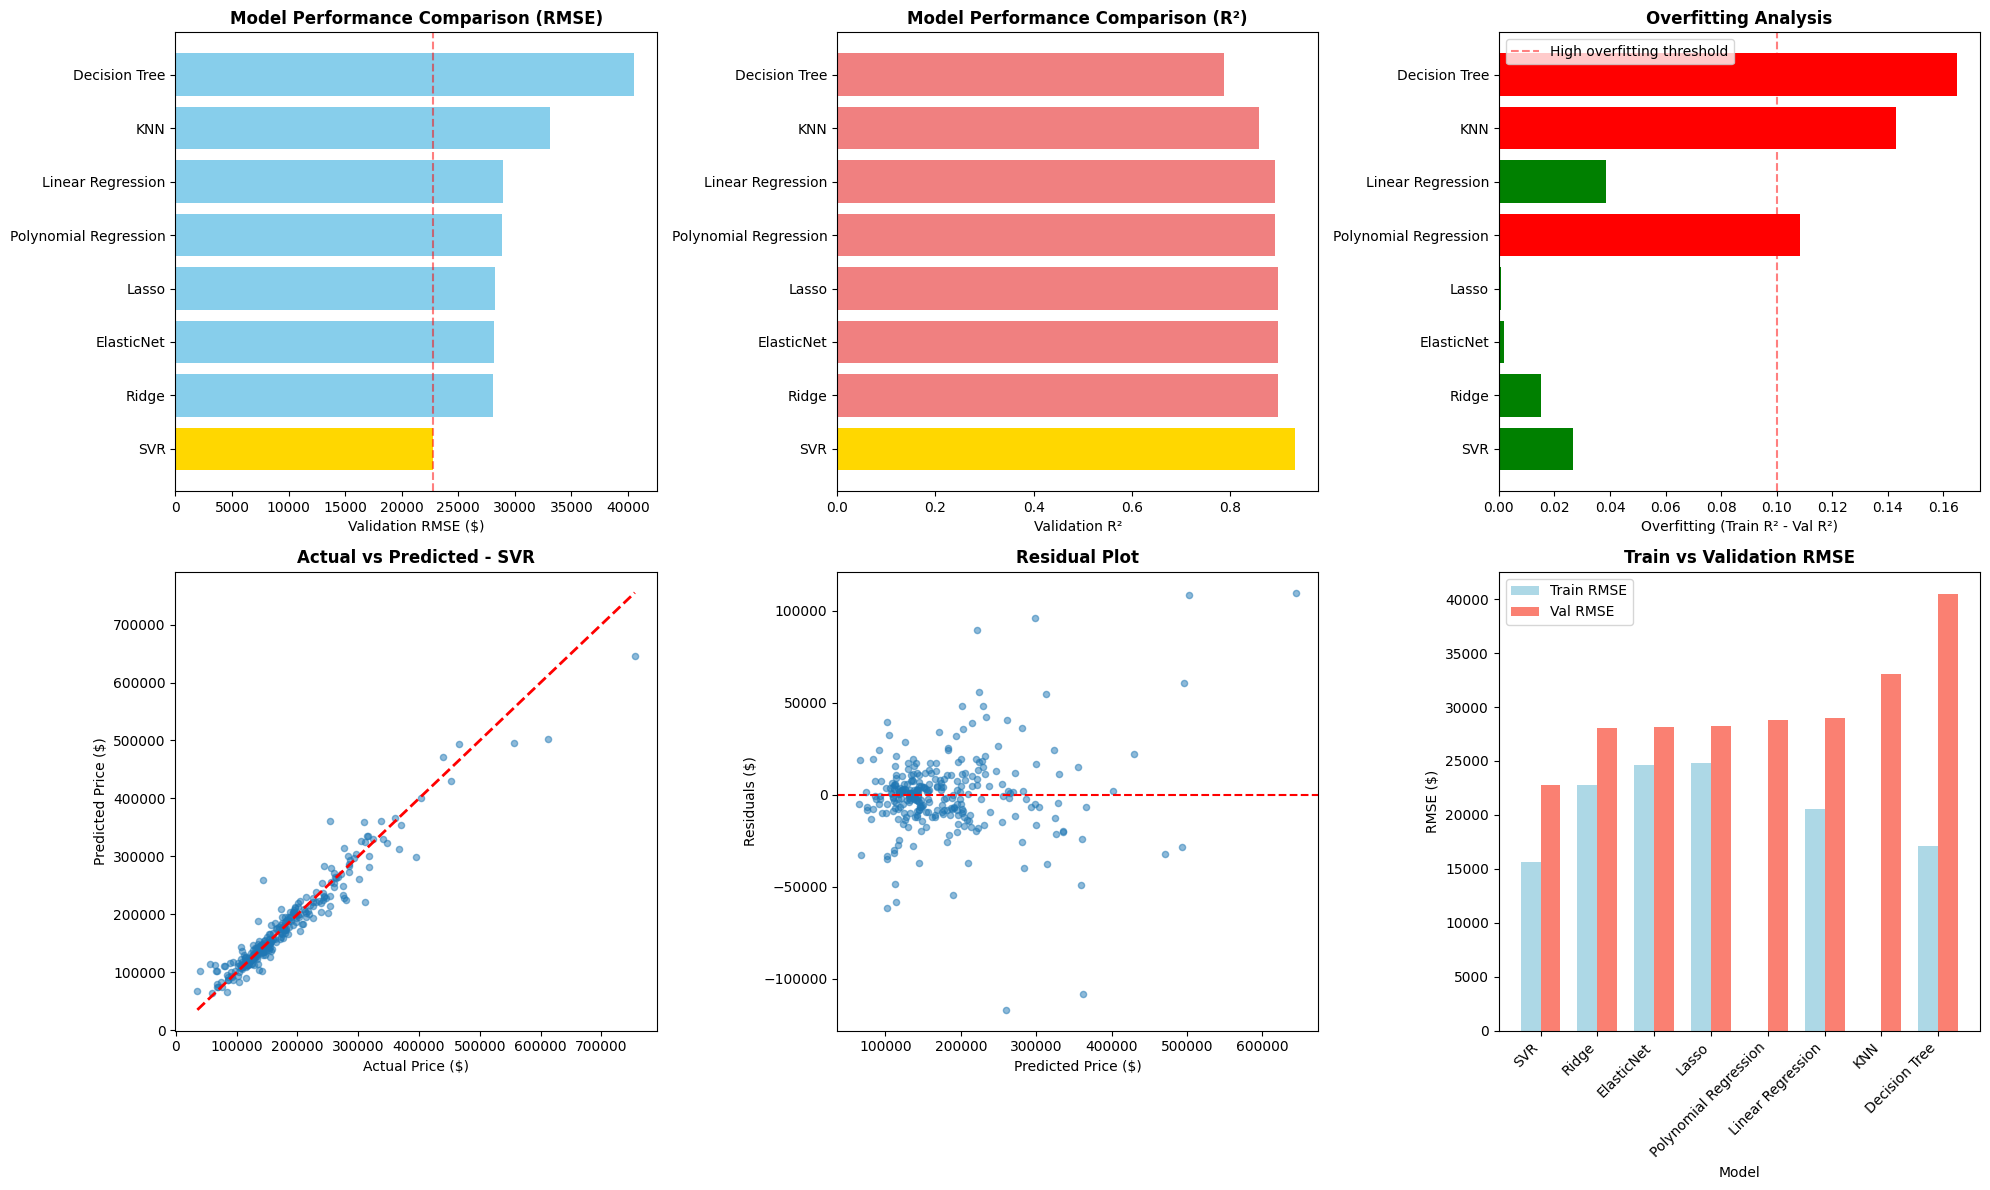


✓ Visualization saved to: images/comprehensive_model_comparison.png
FINAL SUMMARY

✅ MODELS TRAINED: 8
   - With hyperparameter tuning using RandomizedSearchCV
   - 5-fold cross-validation for parameter selection
   - 20 iterations per model (where applicable)

🏆 BEST MODEL: SVR
   - Validation RMSE: $22,792
   - Validation R²: 0.9323
   - Validation MAE: $13,930
   - Overfitting: 0.0266

📊 DIMENSIONALITY REDUCTION:
   - PCA does not help performance
   - Using original features

💾 SAVED FILES:
   1. models/best_model.pkl - Trained model ready for deployment
   2. models/model_metadata.pkl - Model information and parameters
   3. data/model_comparison_results.csv - All model results
   4. images/comprehensive_model_comparison.png - Visualizations





<Figure size 640x480 with 0 Axes>

In [7]:

print("GENERATING VISUALIZATIONS")


fig = plt.figure(figsize=(20, 12))

# 1. Model comparison - RMSE
ax1 = plt.subplot(2, 3, 1)
models_list = results_df_sorted['Model']
val_rmse_list = results_df_sorted['Val_RMSE']
colors = ['gold' if m == best_model_name else 'skyblue' for m in models_list]

ax1.barh(models_list, val_rmse_list, color=colors)
ax1.set_xlabel('Validation RMSE ($)')
ax1.set_title('Model Performance Comparison (RMSE)', fontweight='bold')
ax1.axvline(best_val_rmse, color='red', linestyle='--', alpha=0.5)

# 2. Model comparison - R²
ax2 = plt.subplot(2, 3, 2)
val_r2_list = results_df_sorted['Val_R2']
colors_r2 = ['gold' if m == best_model_name else 'lightcoral' for m in models_list]

ax2.barh(models_list, val_r2_list, color=colors_r2)
ax2.set_xlabel('Validation R²')
ax2.set_title('Model Performance Comparison (R²)', fontweight='bold')

# 3. Overfitting analysis
ax3 = plt.subplot(2, 3, 3)
overfitting_list = results_df_sorted['Overfitting']
colors_overfit = ['red' if o > 0.1 else 'green' for o in overfitting_list]

ax3.barh(models_list, overfitting_list, color=colors_overfit)
ax3.set_xlabel('Overfitting (Train R² - Val R²)')
ax3.set_title('Overfitting Analysis', fontweight='bold')
ax3.axvline(0.1, color='red', linestyle='--', alpha=0.5, label='High overfitting threshold')
ax3.legend()

# 4. Actual vs Predicted (best model)
ax4 = plt.subplot(2, 3, 4)
best_model = trained_models[best_model_name]
y_val_pred_best = best_model.predict(X_val)
y_val_orig = np.expm1(y_val)
y_val_pred_orig = np.expm1(y_val_pred_best)

ax4.scatter(y_val_orig, y_val_pred_orig, alpha=0.5, s=20)
ax4.plot([y_val_orig.min(), y_val_orig.max()], 
         [y_val_orig.min(), y_val_orig.max()], 
         'r--', lw=2)
ax4.set_xlabel('Actual Price ($)')
ax4.set_ylabel('Predicted Price ($)')
ax4.set_title(f'Actual vs Predicted - {best_model_name}', fontweight='bold')

# 5. Residuals plot
ax5 = plt.subplot(2, 3, 5)
residuals = y_val_orig - y_val_pred_orig

ax5.scatter(y_val_pred_orig, residuals, alpha=0.5, s=20)
ax5.axhline(y=0, color='r', linestyle='--')
ax5.set_xlabel('Predicted Price ($)')
ax5.set_ylabel('Residuals ($)')
ax5.set_title('Residual Plot', fontweight='bold')

# 6. Train vs Validation comparison
ax6 = plt.subplot(2, 3, 6)
x_pos = np.arange(len(models_list))
width = 0.35

train_rmse_list = results_df_sorted['Train_RMSE']

ax6.bar(x_pos - width/2, train_rmse_list, width, label='Train RMSE', color='lightblue')
ax6.bar(x_pos + width/2, val_rmse_list, width, label='Val RMSE', color='salmon')

ax6.set_xlabel('Model')
ax6.set_ylabel('RMSE ($)')
ax6.set_title('Train vs Validation RMSE', fontweight='bold')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(models_list, rotation=45, ha='right')
ax6.legend()

plt.tight_layout()
plt.show()
plt.savefig('../images/comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved to: images/comprehensive_model_comparison.png")


print("FINAL SUMMARY")

print(f"""
✅ MODELS TRAINED: {len(models_config)}
   - With hyperparameter tuning using RandomizedSearchCV
   - 5-fold cross-validation for parameter selection
   - 20 iterations per model (where applicable)

🏆 BEST MODEL: {best_model_name}
   - Validation RMSE: ${best_val_rmse:,.0f}
   - Validation R²: {best_val_r2:.4f}
   - Validation MAE: ${results_df_sorted.iloc[0]['Val_MAE']:,.0f}
   - Overfitting: {results_df_sorted.iloc[0]['Overfitting']:.4f}

📊 DIMENSIONALITY REDUCTION:
   - PCA {'helps' if use_pca else 'does not help'} performance
   {'- Best PCA: ' + pca_version_to_use if use_pca else '- Using original features'}

💾 SAVED FILES:
   1. models/best_model.pkl - Trained model ready for deployment
   2. models/model_metadata.pkl - Model information and parameters
   3. data/model_comparison_results.csv - All model results
   4. images/comprehensive_model_comparison.png - Visualizations


""")